In [21]:
!pip install torchdeq
!pip install PyWavelets

Model Parameters: 68,099
Img Size: 196,608
Compression ratio: 0.346


 22%|██▏       | 109/500 [00:02<00:14, 27.52it/s]

[Train] Loss: 0.10955, || PSNR: 15.38 || Lr: [0.009045180463377551]


 42%|████▏     | 210/500 [00:05<00:10, 27.00it/s]

[Train] Loss: 0.08580, || PSNR: 16.40 || Lr: [0.006545430463377552]


 61%|██████    | 305/500 [00:07<00:08, 22.37it/s]

[Train] Loss: 0.07360, || PSNR: 17.15 || Lr: [0.003455569536622448]


 81%|████████  | 406/500 [00:09<00:03, 26.93it/s]

[Train] Loss: 0.06479, || PSNR: 17.78 || Lr: [0.00095581953662245]


100%|██████████| 500/500 [00:12<00:00, 40.71it/s]

[Train] Loss: 0.06514, || PSNR: 18.11 || Lr: [1e-06]


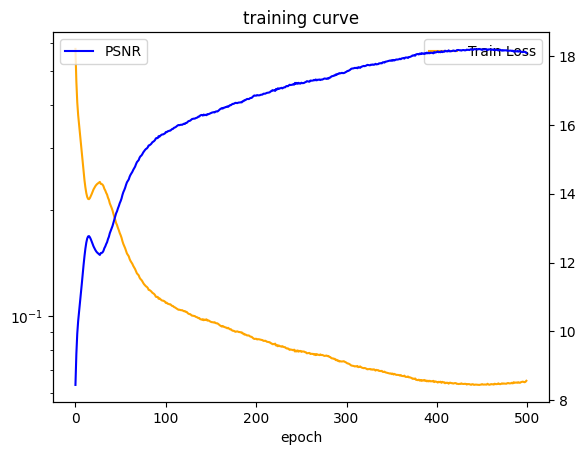

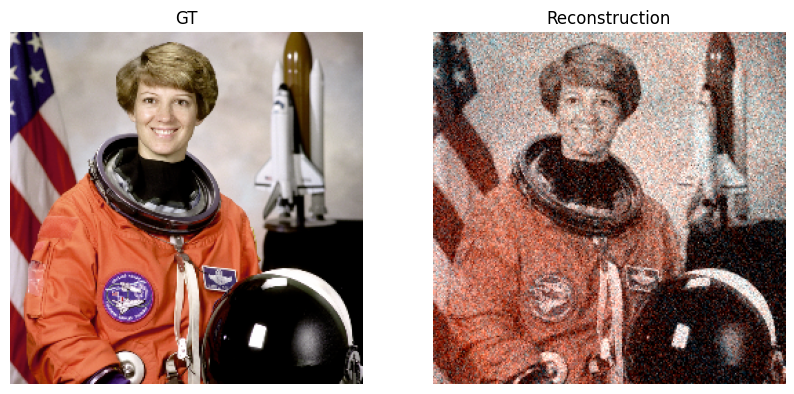

In [65]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchdeq import get_deq
from torchdeq.norm import apply_norm, reset_norm

# Linear Layers
class INRInjection(nn.Linear):
  def __init__(self, in_features, d_hidden, scale=256):
    super().__init__(in_features, d_hidden)
    self.weight.data *= scale
    self.bias.data.uniform_(-np.pi, np.pi)

class MFNLinear(nn.Linear):
  def __init__(self, d_hidden, scale=256):
    super().__init__(d_hidden, d_hidden)
    nn.init.uniform_(self.weight, -np.sqrt(1 / d_hidden), np.sqrt(1 / d_hidden))

# DEQ-INR Base class
class DEQINRBase(nn.Module):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=1, scale=256.,
          deq_mode=True, **kwargs):
    super().__init__()
    self.inj = INRInjection(d_in, d_hidden*(n_layer+1), scale=scale)
    self.mfn = nn.ModuleList([
        MFNLinear(d_hidden, d_hidden) for _ in range(n_layer)
        ])
    self.out = nn.Linear(d_hidden, d_out)
    self.d_hidden = d_hidden
    self.n_layer  = n_layer
    self.register_buffer('z_aux', self._init_z())
    self.deq_mode = deq_mode
    self.deq = get_deq(**kwargs)
    apply_norm(self.mfn, **kwargs)

  def _init_z(self):
    raise NotImplemented

  def injection(self, x):
    raise NotImplemented

  def filter(self, z, u):
    raise NotImplemented

  def mfn_forward(self, z, u):
    # Fixed point reuse
    z = z + self.filter(self.z_aux, u[0])
    for i, layer in enumerate(self.mfn):
      z = self.filter(layer(z), u[i+1])
    return z

  def forward(self, x, z=None):
    reuse = True
    if z is None:
      z = torch.zeros(x.shape[0], self.d_hidden).to(x)
      reuse = False
    u = self.injection(x)
    reset_norm(self.mfn)
    f = lambda z: self.mfn_forward(z, u)
    if self.deq_mode:
      solver_kwargs = {'f_max_iter':0} if reuse else {}
      z_pred, info = self.deq(f, z, solver_kwargs=solver_kwargs)
    else:
      z_pred = [f(z)]
    outputs = [self.out(z) for z in z_pred]
    return outputs, z_pred[-1]

# DEQ-INR Instantiations by different filters
class DEQSirenINR(DEQINRBase):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=1, scale=256.,
          deq_mode=True, **kwargs):
    super().__init__(d_in, d_out, d_hidden, n_layer, scale, deq_mode, **kwargs)

  def _init_z(self):
    return torch.zeros(1, self.d_hidden)

  def injection(self, x):
    u = self.inj(x)
    u = u.chunk(self.n_layer+1, dim=1)
    return u

  def filter(self, z, u):
    return torch.sin(z + u)

def preprocess(x, normalize=False, device=None, dtype=None):
  if normalize:
      x = 2 * x - 1
  B, H, W, C = x.shape
  x = torch.tensor(x, device=device).float()
  return x.reshape(B*H*W, C)

def postprocess(x):
  return torch.clip((x.detach() + 1)/2, 0, 1)

def PSNR(y_orig, y_pred):
  mse = torch.mean((y_orig - y_pred) ** 2)
  max_pixel = 1.0
  psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
  return psnr.item()

def load_data(img, grid_size, device=None, show_img=True):
  if img == 'astronaut':
    image = skimage.data.astronaut()
    dataset = image.reshape(1, 512, 512, 3).astype(np.float32) / 255
  else:
    image = skimage.data.camera()
    dataset = image.reshape(1, 512, 512, 1).astype(np.float32) / 255
  data_channels = dataset.shape[-1]
  RES = image.shape[1]
  full_x = np.linspace(0, 1, RES) * 2 - 1
  full_x_grid = np.stack(np.meshgrid(full_x,full_x), axis=-1)[None, :, :]
  x_train_data = x_test_data = full_x_grid[:, ::RES // grid_size, ::RES // grid_size]
  y_train_data = y_test_data = dataset[:, ::RES // grid_size, ::RES // grid_size]
  x_train = preprocess(x_train_data, device=device)
  y_train = preprocess(y_train_data, normalize=True, device=device)
  return x_train, y_train

def train(model, x_train, y_train, lr=1e-3, log_freq=100):
  n_params = sum(p.numel() for p in model.parameters())
  img_size = y_train.numel()
  print(f'Model Parameters: {n_params:,}')
  print(f'Img Size: {img_size:,}')
  print(f'Compression ratio: {n_params/img_size:.3f}')
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
  loss_log, psnr_log = [], []
  z_star = None
  for i in tqdm(range(epochs)):
    y_pred, z_pred = model(x_train, z_star)
    if deq_mode and reuse:
      z_star = z_pred.detach()
    loss_fn = lambda y_gt, y: ((y_gt - y) ** 2).mean()
    train_loss = loss_fn(y_train, y_pred[-1])
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    loss_log.append(train_loss.item())
    train_psnr = PSNR(postprocess(y_train), postprocess(y_pred[-1]))
    psnr_log.append(train_psnr)
    if (i+1) % log_freq == 0:
      with torch.inference_mode():
        y_pred, _ = model(x_train)
      psnr = PSNR(postprocess(y_train), postprocess(y_pred[-1]))
      print(f"[Train] Loss: {train_loss.item():.5f}, || PSNR: {psnr:.2f} || Lr: {scheduler.get_last_lr()}")
    optimizer.zero_grad()
  return y_pred[-1], loss_log, psnr_log

def plot_training_stats(loss_log, psnr_log):
  fig, ax1 = plt.subplots()
  ax1.plot(loss_log, color='orange', label='Train Loss')
  ax1.set_xlabel("epoch")
  ax1.semilogy()
  ax2 = ax1.twinx()
  ax2.plot(psnr_log, color='b', label='PSNR')
  plt.title("training curve")
  ax1.legend(loc='best')
  ax2.legend(loc='best')

def visualize_results(y_orig, y_pred, grid_size=128):
  y_orig = postprocess(y_orig).detach().cpu().numpy()
  y_pred = postprocess(y_pred).detach().cpu().numpy()
  data_channels = y_orig.shape[-1]
  fig, ax = plt.subplots(1, 2, figsize=(10, 24))
  if data_channels == 1:
    ax[0].imshow(y_orig.reshape(grid_size, grid_size), cmap='gray')
    ax[1].imshow(y_pred.reshape(grid_size, grid_size), cmap='gray')
  else:
    ax[0].imshow(y_orig.reshape((grid_size, grid_size, data_channels)))
    ax[1].imshow(y_pred.reshape((grid_size, grid_size, data_channels)))
  ax[0].set_title("GT")
  ax[0].axis('off')
  ax[1].set_title("Reconstruction")
  ax[1].axis('off')

# Modified Configs
grid_size = 256
img = 'astronaut'
lr = 1e-2
epochs = 500
d_hidden = 256
scale = 256.
deq_mode = True
reuse = True
ift = False
grad = 1
norm_type = 'weight_norm'  # Corrected norm_type
n_layer = 1
device = torch.device('cuda:0')
log_freq = 100

# Training the modified DEQ-INR model
x_train, y_train = load_data(img, grid_size, device=device, show_img=False)
model = DEQSirenINR(d_in=2, d_out=y_train.shape[-1], d_hidden=d_hidden, n_layer=n_layer, scale=scale,
        deq_mode=deq_mode, ift=ift, grad=grad, norm_type=norm_type).to(device)

deq_y_pred, loss_log, psnr_log = train(model, x_train, y_train, lr=lr, log_freq=log_freq)
plot_training_stats(loss_log, psnr_log)
visualize_results(y_train, deq_y_pred, grid_size=grid_size)

Model Parameters: 201,219
Using device: cuda

--- Training at Resolution: 32x32 ---
Target Shape: torch.Size([1024, 3]), Img Size: 3,072
Compression ratio: 65.501


 24%|██▎       | 59/250 [00:00<00:02, 84.98it/s]

[Train] Epoch 50/250 | Loss: 0.00013 | Train PSNR: 45.10 | Val PSNR: 45.90 | Lr: 9.0e-03


 50%|████▉     | 124/250 [00:01<00:00, 136.81it/s]

[Train] Epoch 100/250 | Loss: 0.00000 | Train PSNR: 68.22 | Val PSNR: 68.24 | Lr: 6.5e-03


 72%|███████▏  | 181/250 [00:01<00:00, 164.67it/s]

[Train] Epoch 150/250 | Loss: 0.00000 | Train PSNR: 85.65 | Val PSNR: 85.26 | Lr: 3.5e-03


 90%|█████████ | 225/250 [00:01<00:00, 184.14it/s]

[Train] Epoch 200/250 | Loss: 0.00000 | Train PSNR: 89.87 | Val PSNR: 89.87 | Lr: 9.6e-04


100%|██████████| 250/250 [00:02<00:00, 124.57it/s]


[Train] Epoch 250/250 | Loss: 0.00000 | Train PSNR: 90.00 | Val PSNR: 90.00 | Lr: 1.0e-07

--- Results for Resolution: 32x32 ---


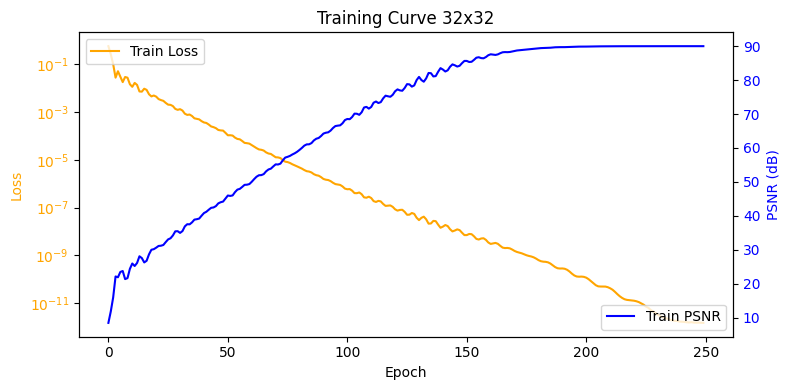

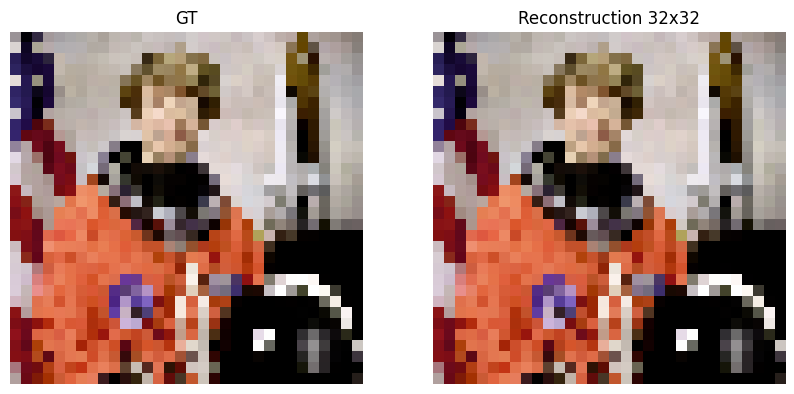

Final Validation PSNR for 32x32: 90.00

--- Training at Resolution: 64x64 ---
Target Shape: torch.Size([4096, 3]), Img Size: 12,288
Compression ratio: 16.375


 36%|███▌      | 89/250 [00:00<00:00, 200.05it/s]

[Train] Epoch 50/250 | Loss: 0.00165 | Train PSNR: 34.13 | Val PSNR: 31.54 | Lr: 4.5e-03


 54%|█████▍    | 136/250 [00:00<00:00, 200.94it/s]

[Train] Epoch 100/250 | Loss: 0.00044 | Train PSNR: 39.93 | Val PSNR: 36.24 | Lr: 3.3e-03


 73%|███████▎  | 182/250 [00:00<00:00, 197.25it/s]

[Train] Epoch 150/250 | Loss: 0.00012 | Train PSNR: 45.57 | Val PSNR: 40.81 | Lr: 1.7e-03


 91%|█████████ | 228/250 [00:01<00:00, 198.38it/s]

[Train] Epoch 200/250 | Loss: 0.00004 | Train PSNR: 50.59 | Val PSNR: 43.69 | Lr: 4.8e-04


100%|██████████| 250/250 [00:01<00:00, 187.09it/s]


[Train] Epoch 250/250 | Loss: 0.00004 | Train PSNR: 50.12 | Val PSNR: 44.67 | Lr: 1.0e-07

--- Results for Resolution: 64x64 ---


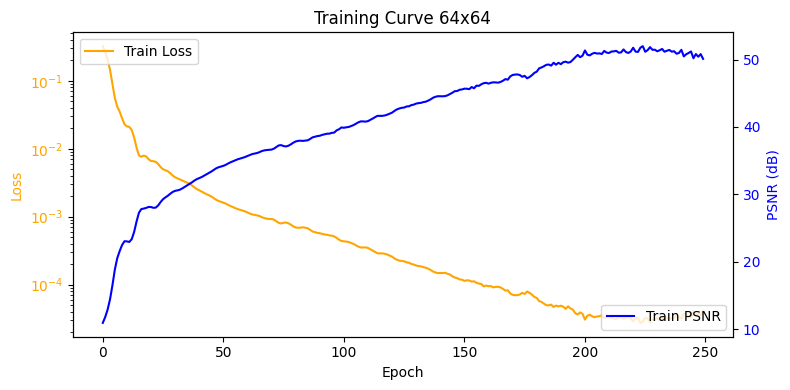

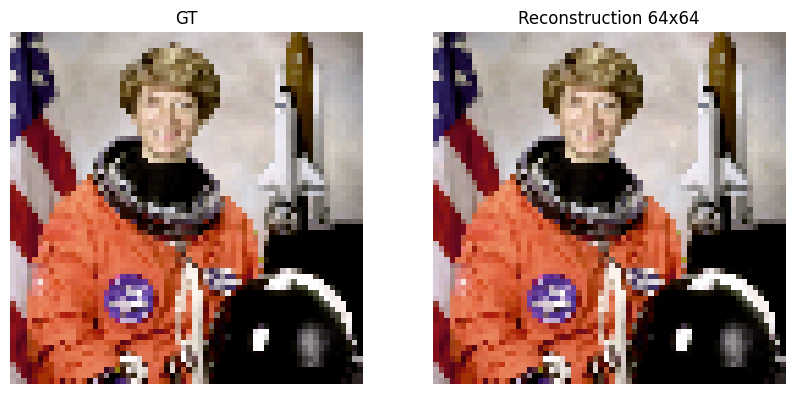

Final Validation PSNR for 64x64: 44.67

--- Training at Resolution: 128x128 ---
Target Shape: torch.Size([16384, 3]), Img Size: 49,152
Compression ratio: 4.094


 25%|██▌       | 63/250 [00:00<00:03, 56.32it/s]

[Train] Epoch 50/250 | Loss: 0.01107 | Train PSNR: 25.87 | Val PSNR: 25.19 | Lr: 9.0e-04


 47%|████▋     | 117/250 [00:01<00:02, 59.35it/s]

[Train] Epoch 100/250 | Loss: 0.00419 | Train PSNR: 30.05 | Val PSNR: 28.64 | Lr: 6.5e-04


 64%|██████▍   | 161/250 [00:02<00:01, 56.64it/s]

[Train] Epoch 150/250 | Loss: 0.00281 | Train PSNR: 31.77 | Val PSNR: 30.36 | Lr: 3.5e-04


 86%|████████▌ | 215/250 [00:03<00:00, 58.38it/s]

[Train] Epoch 200/250 | Loss: 0.00239 | Train PSNR: 32.50 | Val PSNR: 31.43 | Lr: 9.6e-05


100%|██████████| 250/250 [00:03<00:00, 63.66it/s]

[Train] Epoch 250/250 | Loss: 0.00258 | Train PSNR: 32.15 | Val PSNR: 31.64 | Lr: 1.0e-07

--- Results for Resolution: 128x128 ---


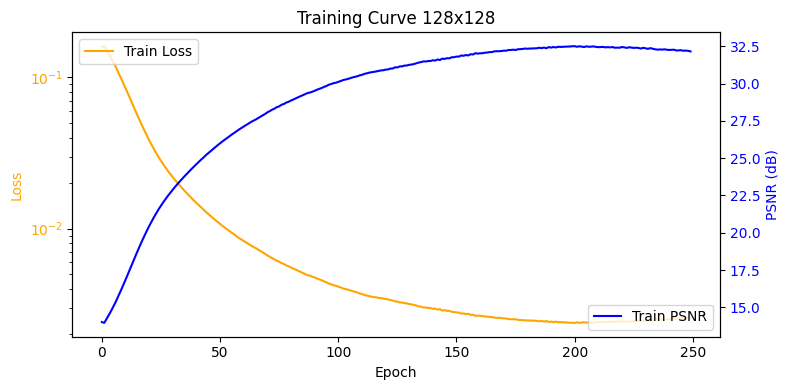

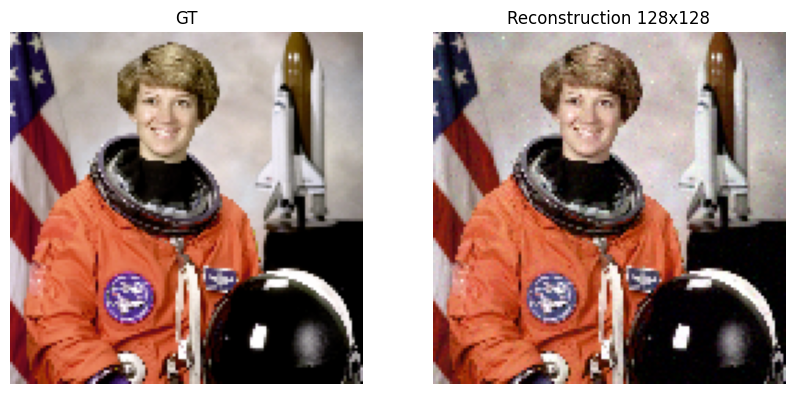

Final Validation PSNR for 128x128: 31.64

--- Training at Resolution: 256x256 ---
Target Shape: torch.Size([65536, 3]), Img Size: 196,608
Compression ratio: 1.023


 21%|██        | 53/250 [00:03<00:22,  8.86it/s]

[Train] Epoch 50/250 | Loss: 0.01126 | Train PSNR: 25.78 | Val PSNR: 25.66 | Lr: 9.0e-04


 41%|████      | 103/250 [00:06<00:16,  8.69it/s]

[Train] Epoch 100/250 | Loss: 0.00622 | Train PSNR: 28.36 | Val PSNR: 28.23 | Lr: 6.5e-04


 61%|██████    | 153/250 [00:09<00:11,  8.74it/s]

[Train] Epoch 150/250 | Loss: 0.00467 | Train PSNR: 29.61 | Val PSNR: 29.51 | Lr: 3.5e-04


 81%|████████  | 203/250 [00:12<00:05,  8.69it/s]

[Train] Epoch 200/250 | Loss: 0.00418 | Train PSNR: 30.10 | Val PSNR: 30.07 | Lr: 9.6e-05


100%|██████████| 250/250 [00:15<00:00, 16.14it/s]

[Train] Epoch 250/250 | Loss: 0.00411 | Train PSNR: 30.17 | Val PSNR: 30.16 | Lr: 1.0e-07

--- Results for Resolution: 256x256 ---


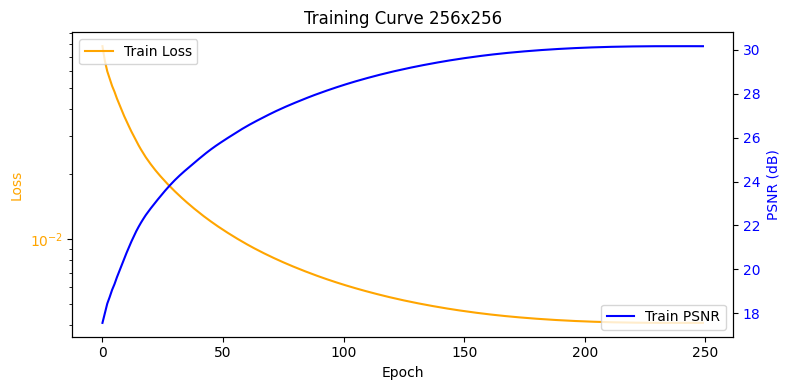

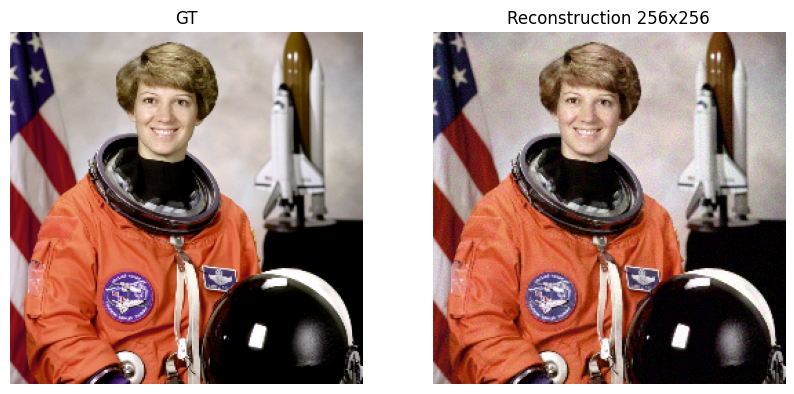

Final Validation PSNR for 256x256: 30.16

--- Final Model Evaluation (Highest Resolution) ---
Final Evaluation PSNR (256x256): 30.16 dB


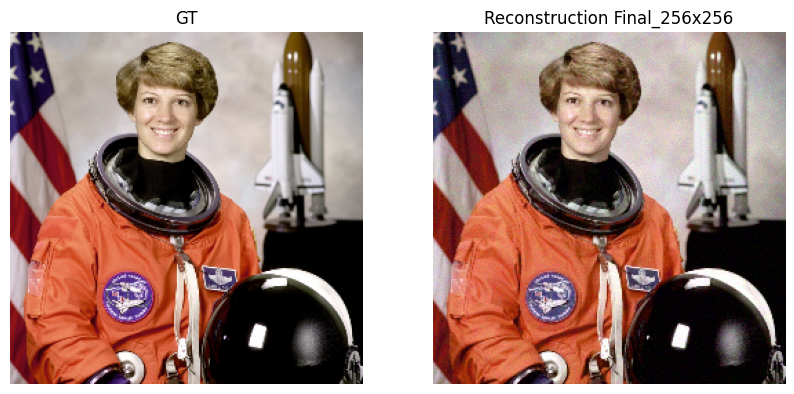

In [62]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchdeq import get_deq
from torchdeq.norm import apply_norm, reset_norm
# No pandas needed anymore

# --- Network Components (Unchanged) ---
class INRInjection(nn.Linear):
  def __init__(self, in_features, d_hidden, scale=256):
    super().__init__(in_features, d_hidden)
    self.weight.data *= scale
    self.bias.data.uniform_(-np.pi, np.pi)

class MFNLinear(nn.Linear):
  def __init__(self, d_hidden, scale=256):
    super().__init__(d_hidden, d_hidden)
    nn.init.uniform_(self.weight, -np.sqrt(1 / d_hidden), np.sqrt(1 / d_hidden))

# DEQ-INR Base class
class DEQINRBase(nn.Module):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=1, scale=256.,
         deq_mode=True, **kwargs):
    super().__init__()
    self.inj = INRInjection(d_in, d_hidden*(n_layer+1), scale=scale)
    self.mfn = nn.ModuleList([
        MFNLinear(d_hidden, d_hidden) for _ in range(n_layer)
        ])
    self.out = nn.Linear(d_hidden, d_out)
    self.d_hidden = d_hidden
    self.n_layer  = n_layer
    self.register_buffer('z_aux', self._init_z())
    self._deq_mode = deq_mode # Use internal flag
    self.deq = get_deq(**kwargs)
    # apply_norm might have issues if kwargs doesn't contain norm_type, handle carefully
    if 'norm_type' in kwargs and kwargs['norm_type']:
        try: # Add try-except for apply_norm
            apply_norm(self.mfn, **kwargs)
        except Exception as e:
            print(f"Warning: Failed to apply norm with kwargs {kwargs}. Error: {e}")

  # Use property to manage deq_mode
  @property
  def deq_mode(self):
      return self._deq_mode

  @deq_mode.setter
  def deq_mode(self, value):
      self._deq_mode = value

  def _init_z(self):
    raise NotImplementedError("Subclasses should implement this.")

  def injection(self, x):
    raise NotImplementedError("Subclasses should implement this.")

  def filter(self, z, u):
    raise NotImplementedError("Subclasses should implement this.")

  def mfn_forward(self, z, u):
    # Fixed point reuse base logic
    z_aux_expanded = self.z_aux.expand(z.shape[0], -1) if z.shape[0] != self.z_aux.shape[0] else self.z_aux
    z = z + self.filter(z_aux_expanded, u[0])
    for i, layer in enumerate(self.mfn):
      z = self.filter(layer(z), u[i+1])
    return z

  def forward(self, x, z=None):
    reuse = True
    if z is None:
      z = torch.zeros(x.shape[0], self.d_hidden).to(x)
      reuse = False

    # Adapt z_star for new resolution
    if reuse and z.shape[0] != x.shape[0]:
        if z.numel() > 0: # Check if z has elements
             z_adapted = z.mean(0, keepdim=True).expand(x.shape[0], -1).to(x.device, x.dtype)
             z = z_adapted
        else: # Handle empty tensor case
             z = torch.zeros(x.shape[0], self.d_hidden).to(x)
             reuse = False

    u = self.injection(x)
    # Consider removing reset_norm if using spectral norm or causing issues
    # try:
    #     reset_norm(self.mfn)
    # except Exception as e:
    #     print(f"Warning: reset_norm failed. Error: {e}")

    f = lambda z_inner: self.mfn_forward(z_inner, u)

    if self.deq_mode: # Access property
      solver_kwargs_default = {}
      solver_kwargs = {'f_max_iter':0} if reuse else solver_kwargs_default
      try:
          z_pred, info = self.deq(f, z, solver_kwargs=solver_kwargs)
          if not isinstance(z_pred, list): # Ensure z_pred is a list
              z_pred = [z_pred]
      except Exception as e:
          print(f"Error during DEQ solve: {e}")
          z_pred = [z] # Fallback
          info = {'err': True}
    else:
      z_pred = [f(z)] # Run only one step

    if not z_pred:
        print("Warning: z_pred list is empty. Returning zero output.")
        output_shape = (x.shape[0], self.out.out_features)
        outputs = [torch.zeros(output_shape, device=x.device, dtype=x.dtype)]
        z_final_state = torch.zeros(x.shape[0], self.d_hidden).to(x)
    else:
        outputs = [self.out(zp) for zp in z_pred]
        z_final_state = z_pred[-1]

    return outputs, z_final_state

# DEQ-INR Instantiations by different filters
class DEQSirenINR(DEQINRBase):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=1, scale=256.,
         deq_mode=True, **kwargs):
    super().__init__(d_in, d_out, d_hidden, n_layer, scale, deq_mode, **kwargs)

  def _init_z(self):
    return torch.zeros(1, self.d_hidden)

  def injection(self, x):
    u = self.inj(x)
    u = u.chunk(self.n_layer+1, dim=1)
    return u

  def filter(self, z, u):
    return torch.sin(z + u)

# --- Helper Functions ---
def preprocess(x, normalize=False, device=None, dtype=None):
  if normalize:
      x = 2 * x - 1
  B, H, W, C = x.shape
  x = torch.tensor(x, device=device, dtype=torch.float32 if dtype is None else dtype)
  return x.reshape(B*H*W, C)

def postprocess(x):
  return torch.clip((x.detach().float() + 1)/2, 0, 1)

def PSNR(y_orig, y_pred):
    y_orig_f = y_orig.float().to(y_pred.device)
    y_pred_f = y_pred.float()
    if torch.isnan(y_orig_f).any() or torch.isnan(y_pred_f).any():
        print("Warning: NaN detected in PSNR input.")
        return float('nan')
    mse = torch.mean((y_orig_f - y_pred_f) ** 2) + 1e-9
    if mse <= 1e-9:
        return float('inf')
    if mse <= 0:
        print(f"Warning: Non-positive MSE detected ({mse}). Returning NaN PSNR.")
        return float('nan')
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    if torch.isnan(psnr):
        print(f"Warning: NaN PSNR calculated (MSE={mse}).")
        return float('nan')
    return psnr.item()

def load_data(img, grid_size, device=None, show_img=True):
  try:
    if img == 'astronaut':
      image = skimage.data.astronaut()
      dataset = image.astype(np.float32).reshape(1, 512, 512, 3) / 255.0
    else:
      image = skimage.data.camera()
      dataset = image.astype(np.float32).reshape(1, 512, 512, 1) / 255.0
  except Exception as e:
      print(f"Error loading image data '{img}': {e}")
      return None, None

  data_channels = dataset.shape[-1]
  RES = image.shape[1]
  step = max(1, RES // grid_size)
  full_x = np.linspace(0, 1, RES, dtype=np.float32)
  full_x_grid = np.stack(np.meshgrid(full_x, full_x, indexing='ij'), axis=-1)[None, :, :]

  x_train_data = full_x_grid[:, ::step, ::step]
  y_train_data = dataset[:, ::step, ::step]

  if x_train_data.size == 0 or y_train_data.size == 0:
       print(f"Warning: Subsampling resulted in empty data for grid size {grid_size}.")
       return None, None

  x_train = preprocess(x_train_data, normalize=False, device=device)
  y_train = preprocess(y_train_data, normalize=True, device=device)
  return x_train, y_train

# Modified train function
def train(model, x_train, y_train, z_star, epochs, lr=1e-3, log_freq=100, current_deq_mode=True, current_reuse=True):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)
  loss_log, psnr_log = [], []
  last_val_psnr = float('nan')
  model.train()
  model.deq_mode = current_deq_mode

  for i in tqdm(range(epochs)):
    try:
        y_pred_list, z_pred_state = model(x_train, z_star)
        if not y_pred_list:
            print(f"Epoch {i+1}: Forward pass returned empty prediction list. Skipping epoch.")
            z_star = None
            continue
        final_y_pred = y_pred_list[-1]

        if current_reuse:
            if z_pred_state is not None and isinstance(z_pred_state, torch.Tensor):
                z_star = z_pred_state.detach()
            else: z_star = None
        else: z_star = None

        loss_fn = lambda y_gt, y: ((y_gt.float() - y.float()) ** 2).mean()
        train_loss = loss_fn(y_train, final_y_pred)

        if torch.isnan(train_loss) or torch.isinf(train_loss):
            print(f"Epoch {i+1}: NaN or Inf loss detected ({train_loss.item()}). Stopping training for this stage.")
            return final_y_pred, loss_log, psnr_log, float('nan'), z_star

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

        loss_log.append(train_loss.item())
        train_psnr = PSNR(postprocess(y_train), postprocess(final_y_pred))
        psnr_log.append(train_psnr)

        if (i+1) % log_freq == 0:
          model.eval()
          with torch.inference_mode():
            y_val_pred_list, _ = model(x_train, z=None)
          if y_val_pred_list:
               last_val_psnr = PSNR(postprocess(y_train), postprocess(y_val_pred_list[-1]))
          else: last_val_psnr = float('nan')
          print(f"[Train] Epoch {i+1}/{epochs} | Loss: {train_loss.item():.5f} | Train PSNR: {train_psnr:.2f} | Val PSNR: {last_val_psnr:.2f} | Lr: {scheduler.get_last_lr()[0]:.1e}")
          model.train()

    except Exception as e:
        print(f"Error during training epoch {i+1}: {e}")
        return final_y_pred if 'final_y_pred' in locals() else None, loss_log, psnr_log, float('nan'), z_star

  if 'final_y_pred' not in locals(): final_y_pred = None
  return final_y_pred, loss_log, psnr_log, last_val_psnr, z_star

# --- Plotting and Visualization (Show directly) ---
def plot_training_stats(loss_log, psnr_log, title=""):
  if not loss_log or not psnr_log:
      print(f"Skipping plot for {title}: Empty logs.")
      return
  try:
      fig, ax1 = plt.subplots(figsize=(8, 4))
      ax1.plot(loss_log, color='orange', label='Train Loss')
      ax1.set_xlabel("Epoch")
      ax1.set_ylabel("Loss", color='orange')
      ax1.semilogy()
      ax1.tick_params(axis='y', labelcolor='orange')
      ax1.legend(loc='upper left')

      ax2 = ax1.twinx()
      ax2.plot(psnr_log, color='b', label='Train PSNR')
      ax2.set_ylabel('PSNR (dB)', color='b')
      ax2.tick_params(axis='y', labelcolor='b')
      ax2.legend(loc='lower right')

      plt.title(f"Training Curve {title}")
      fig.tight_layout()
      plt.show() # Display the plot directly
      # plt.close(fig) # Close after showing if needed, but show leaves it open
  except Exception as e:
      print(f"Error generating plot for {title}: {e}")
      if 'fig' in locals() and plt.fignum_exists(fig.number):
          plt.close(fig)

def visualize_results(y_orig, y_pred, grid_size, title=""):
    if y_orig is None or y_pred is None:
        print(f"Skipping visualization for {title}: Missing data.")
        return
    try:
        y_orig_np = postprocess(y_orig).cpu().numpy()
        y_pred_np = postprocess(y_pred).cpu().numpy()

        if np.any(np.isnan(y_pred_np)) or np.any(np.isinf(y_pred_np)):
            print(f"Warning: NaN or Inf detected in prediction for {title}. Skipping visualization.")
            return

        try:
            target_shape = (grid_size, grid_size, -1) if y_orig_np.shape[-1] > 1 else (grid_size, grid_size)
            y_orig_reshaped = y_orig_np.reshape(target_shape).squeeze()
            y_pred_reshaped = y_pred_np.reshape(target_shape).squeeze()
            data_channels = y_orig_np.shape[-1]
        except Exception as reshape_e:
             print(f"Error reshaping images for visualization ({title}): {reshape_e}")
             return

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        cmap = 'gray' if data_channels == 1 else None
        vmin = y_orig_np.min()
        vmax = y_orig_np.max()

        ax[0].imshow(y_orig_reshaped, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[0].set_title("GT")
        ax[0].axis('off')

        ax[1].imshow(y_pred_reshaped, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[1].set_title(f"Reconstruction {title}")
        ax[1].axis('off')

        plt.show() # Display the image comparison directly
        # plt.close(fig) # Close after showing if needed

    except Exception as e:
        print(f"Error during visualization for {title}: {e}")
        if 'fig' in locals() and plt.fignum_exists(fig.number):
             plt.close(fig)

# --- Configs ---
img = 'astronaut'
epochs_per_stage = 250
d_hidden = 256
scale = 256.
deq_mode = True
reuse = True
ift = False
grad = 1
norm_type = 'weight_norm'
n_layer = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log_freq = 50

resolution_stages = [32, 64, 128, 256]
learning_rates = [1e-2, 5e-3, 1e-3, 1e-3]

# --- Model Initialization ---
try:
    temp_img = skimage.data.astronaut() if img == 'astronaut' else skimage.data.camera()
    d_out = 3 if temp_img.ndim == 3 and temp_img.shape[-1] == 3 else 1
except Exception as e:
    print(f"Error determining output channels from image '{img}': {e}")
    d_out = 3 # Default

model = DEQSirenINR(d_in=2, d_out=d_out,
                    d_hidden=d_hidden, n_layer=n_layer, scale=scale,
                    deq_mode=deq_mode, ift=ift, grad=grad, norm_type=norm_type).to(device)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Using device: {device}")

# --- Multi-Resolution Training Loop ---
z_star = None
# No table data collection needed now

for grid_size, stage_lr in zip(resolution_stages, learning_rates):
    stage_title = f"{grid_size}x{grid_size}"
    print(f"\n--- Training at Resolution: {stage_title} ---")

    x_train, y_train = load_data(img, grid_size, device=device, show_img=False)

    if x_train is None or y_train is None:
        print(f"Skipping stage {stage_title} due to data loading error.")
        continue

    current_img_size = y_train.numel()
    print(f'Target Shape: {y_train.shape}, Img Size: {current_img_size:,}')
    compression_ratio = sum(p.numel() for p in model.parameters()) / current_img_size if current_img_size > 0 else float('inf')
    print(f'Compression ratio: {compression_ratio:.3f}')

    y_pred, loss_log, psnr_log, final_val_psnr, z_star = train(
        model, x_train, y_train, z_star,
        epochs=epochs_per_stage,
        lr=stage_lr,
        log_freq=log_freq,
        current_deq_mode=deq_mode,
        current_reuse=reuse
    )

    # --- Display Plot and Images ---
    print(f"\n--- Results for Resolution: {stage_title} ---")
    plot_training_stats(loss_log, psnr_log, title=stage_title)
    if y_pred is not None:
        visualize_results(y_train, y_pred, grid_size, title=stage_title)
    else:
        print("Skipping visualization due to error during training.")
    print(f"Final Validation PSNR for {stage_title}: {final_val_psnr:.2f}" if not np.isnan(final_val_psnr) else "NaN")
    # -------------------------------

    if np.isnan(final_val_psnr):
        print(f"Warning: NaN PSNR detected at end of stage {stage_title}. Stopping.")
        break # Stop if a stage fails badly

# --- Final Model Evaluation ---
print("\n--- Final Model Evaluation (Highest Resolution) ---")
final_grid_size = resolution_stages[-1]
x_final, y_final = load_data(img, final_grid_size, device=device, show_img=False)

if x_final is not None and y_final is not None:
    model.eval()
    with torch.inference_mode():
        y_final_pred_list, _ = model(x_final, z=None) # Start fresh

    if y_final_pred_list:
        final_psnr_eval = PSNR(postprocess(y_final), postprocess(y_final_pred_list[-1]))
        print(f"Final Evaluation PSNR ({final_grid_size}x{final_grid_size}): {final_psnr_eval:.2f} dB")
        visualize_results(y_final, y_final_pred_list[-1], grid_size=final_grid_size, title=f"Final_{final_grid_size}x{final_grid_size}")
    else:
        print("Final prediction list was empty. Skipping final visualization.")
else:
    print(f"Could not load data for final resolution {final_grid_size}. Skipping final evaluation.")

Model Parameters: 201,219
Img Size: 196,608
Compression ratio: 1.023

--- STAGE 1: Pre-training as a 'Shallow' Feed-Forward INR ---


 41%|████      | 102/250 [00:09<00:12, 11.62it/s]

[Train] Loss: 0.00248, || PSNR: 32.15 || Lr: [0.0065454304633775565]


 81%|████████  | 202/250 [00:18<00:03, 12.08it/s]

[Train] Loss: 0.00219, || PSNR: 32.71 || Lr: [0.0009558195366224514]


100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


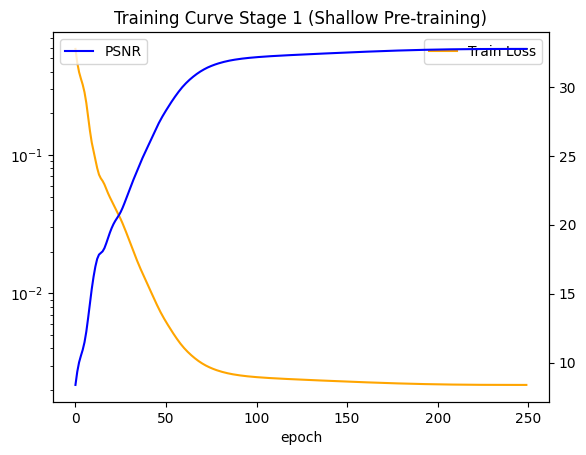

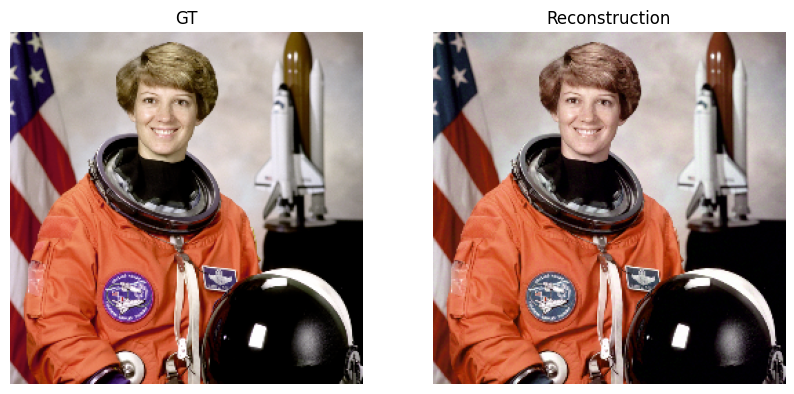

--- STAGE 1 Complete - Final PSNR: 32.75 dB ---

--- STAGE 2: Fine-tuning 'Shallow' Model with DSNR ---


 41%|████      | 102/250 [00:08<00:12, 11.41it/s]

[Train] Loss: 0.00235, || PSNR: 32.43 || Lr: [6.890576474687276e-06]


 81%|████████  | 202/250 [00:17<00:04, 10.61it/s]

[Train] Loss: 0.00235, || PSNR: 32.43 || Lr: [1.8594235253127411e-06]


100%|██████████| 250/250 [00:21<00:00, 11.71it/s]


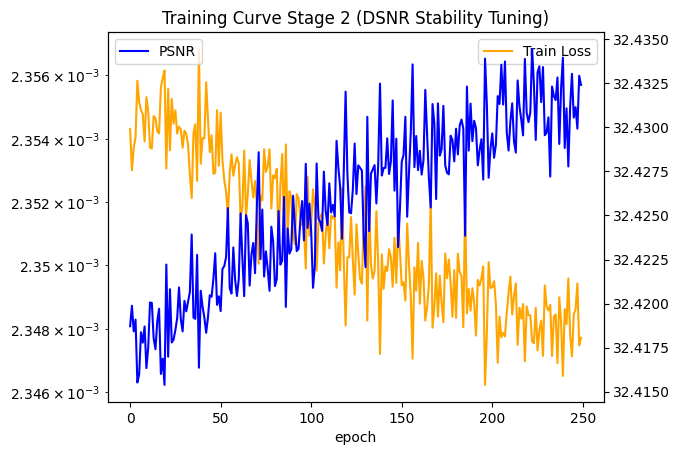

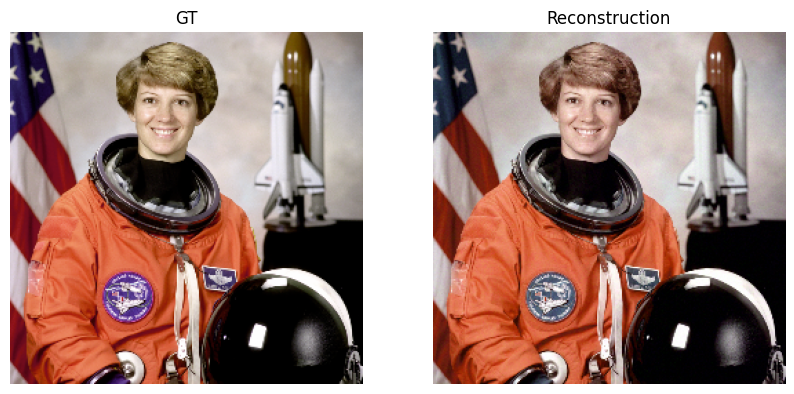

--- STAGE 2 Complete - Final PSNR: 32.43 dB ---

--- STAGE 3: Fine-tuning 'Deep' Equilibrium Model ---


 40%|████      | 101/250 [00:09<00:30,  4.94it/s]

[Train] Loss: 0.33190, || PSNR: 11.23 || Lr: [1e-06]


 80%|████████  | 201/250 [00:17<00:09,  4.97it/s]

[Train] Loss: 0.33048, || PSNR: 11.25 || Lr: [1e-06]


100%|██████████| 250/250 [00:21<00:00, 11.55it/s]


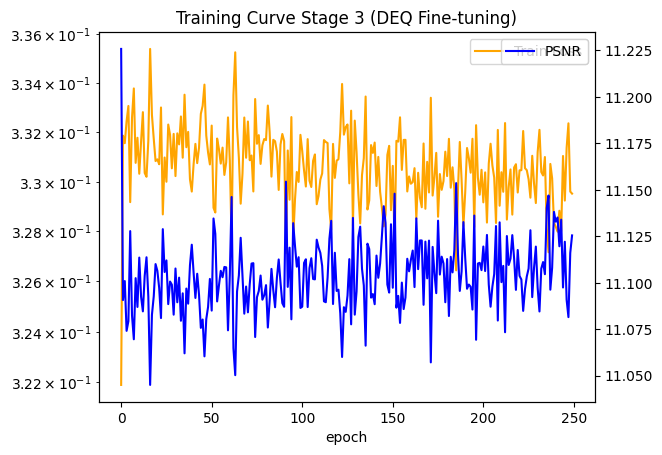

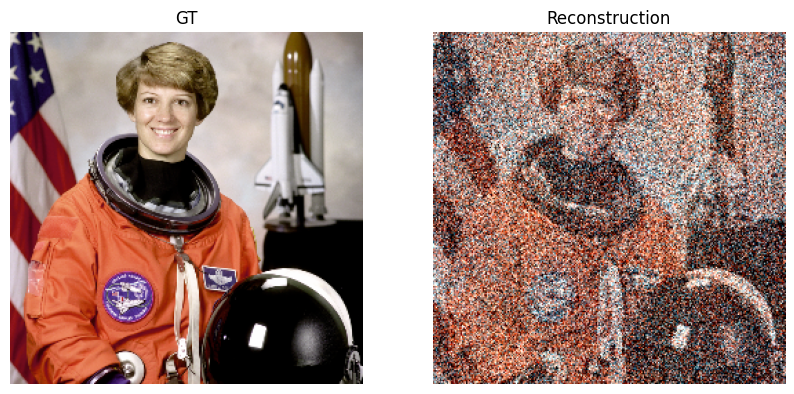

--- STAGE 3 Complete - Final PSNR: 11.13 dB ---


In [66]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchdeq import get_deq
from torchdeq.norm import apply_norm, reset_norm

# Linear Layers
class INRInjection(nn.Linear):
  def __init__(self, in_features, d_hidden, scale=256):
    super().__init__(in_features, d_hidden)
    self.weight.data *= scale
    self.bias.data.uniform_(-np.pi, np.pi)

class MFNLinear(nn.Linear):
  def __init__(self, d_hidden, scale=256):
    super().__init__(d_hidden, d_hidden)
    nn.init.uniform_(self.weight, -np.sqrt(1 / d_hidden), np.sqrt(1 / d_hidden))

# DEQ-INR Base class
class DEQINRBase(nn.Module):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=3, scale=256.,
         deq_mode=True, **kwargs):
    super().__init__()
    self.inj = INRInjection(d_in, d_hidden*(n_layer+1), scale=scale)
    self.mfn = nn.ModuleList([
        MFNLinear(d_hidden, d_hidden) for _ in range(n_layer)
        ])
    self.out = nn.Linear(d_hidden, d_out)
    self.d_hidden = d_hidden
    self.n_layer  = n_layer
    self.register_buffer('z_aux', self._init_z())
    self._deq_mode = deq_mode

    # Use Anderson Acceleration for stable/fast solve
    self.deq_solver_kwargs = {'f_solver': 'anderson', 'm': 5, 'beta': 1.2, 'f_max_iter': 25}
    deq_kwargs = kwargs.copy()
    deq_kwargs.update(self.deq_solver_kwargs)
    self.deq = get_deq(**deq_kwargs)

    apply_norm(self.mfn, **kwargs)

    # --- ADVANCEMENT: DSNR Noise Knob ---
    self.dsnr_noise_std = 0.0
    # ------------------------------------

  # Property to control DEQ mode
  @property
  def deq_mode(self):
      return self._deq_mode

  @deq_mode.setter
  def deq_mode(self, value):
      self._deq_mode = value

  def _init_z(self):
    raise NotImplemented

  def injection(self, x):
    raise NotImplemented

  def filter(self, z, u):
    raise NotImplemented

  def mfn_forward(self, z, u):
    # This is the function f(z, u) that is iterated

    # The first line uses z (z_k) or 0 (in stage 1)
    z = z + self.filter(self.z_aux, u[0])

    # --- ADVANCEMENT: DSNR Injection (Stage 2 Only) ---
    # We add noise *after* the first step, forcing the mfn
    # layers to be robust to perturbations.
    if self.training and self.dsnr_noise_std > 0:
        z = z + torch.randn_like(z) * self.dsnr_noise_std
    # ----------------------------------------------------

    for i, layer in enumerate(self.mfn):
      z = self.filter(layer(z), u[i+1])
    return z

  def forward(self, x, z=None):
    reuse = True
    if z is None:
      z = torch.zeros(x.shape[0], self.d_hidden).to(x)
      reuse = False
    u = self.injection(x)
    reset_norm(self.mfn)
    f = lambda z: self.mfn_forward(z, u)

    if not self.deq_mode:
        # STAGE 1 & 2 (Shallow): Run one step as a feed-forward network
        z_pred = [f(z)]
    else:
        # STAGE 3 (Deep): Run the full DEQ solver
        solver_kwargs = {'f_max_iter': 0} if reuse else {}
        z_pred, info = self.deq(f, z, solver_kwargs=solver_kwargs)

    outputs = [self.out(z) for z in z_pred]
    return outputs, z_pred[-1]

# DEQ-INR Instantiations by different filters
class DEQSirenINR(DEQINRBase):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=3, scale=256.,
         deq_mode=True, **kwargs):
    super().__init__(d_in, d_out, d_hidden, n_layer, scale, deq_mode, **kwargs)

  def _init_z(self):
    return torch.zeros(1, self.d_hidden)

  def injection(self, x):
    u = self.inj(x)
    u = u.chunk(self.n_layer+1, dim=1)
    return u

  def filter(self, z, u):
    return torch.sin(z + u)

def preprocess(x, normalize=False, device=None, dtype=None):
  if normalize:
      x = 2 * x - 1
  B, H, W, C = x.shape
  x = torch.tensor(x, device=device).float()
  return x.reshape(B*H*W, C)

def postprocess(x):
  return torch.clip((x.detach() + 1)/2, 0, 1)

def PSNR(y_orig, y_pred):
  mse = torch.mean((y_orig - y_pred) ** 2)
  max_pixel = 1.0
  psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
  return psnr.item()

def load_data(img, grid_size, device=None, show_img=True):
  if img == 'astronaut':
    image = skimage.data.astronaut()
    dataset = image.reshape(1, 512, 512, 3).astype(np.float32) / 255
  else:
    image = skimage.data.camera()
    dataset = image.reshape(1, 512, 512, 1).astype(np.float32) / 255
  data_channels = dataset.shape[-1]
  RES = image.shape[1]
  full_x = np.linspace(0, 1, RES) * 2 - 1
  full_x_grid = np.stack(np.meshgrid(full_x,full_x), axis=-1)[None, :, :]
  x_train_data = x_test_data = full_x_grid[:, ::RES // grid_size, ::RES // grid_size]
  y_train_data = y_test_data = dataset[:, ::RES // grid_size, ::RES // grid_size]
  x_train = preprocess(x_train_data, device=device)
  y_train = preprocess(y_train_data, normalize=True, device=device)
  return x_train, y_train

def train(model, x_train, y_train, epochs, lr=1e-3, log_freq=100):
  # Set up a new optimizer and scheduler for this training stage
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
  loss_log, psnr_log = [], []
  z_star = None

  for i in tqdm(range(epochs)):
    y_pred, z_pred = model(x_train, z_star)
    final_y_pred = y_pred[-1]

    if model.deq_mode and reuse:
      z_star = z_pred.detach()

    loss_fn = lambda y_gt, y: ((y_gt - y) ** 2).mean()
    train_loss = loss_fn(y_train, final_y_pred)
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    loss_log.append(train_loss.item())

    train_psnr = PSNR(postprocess(y_train), postprocess(final_y_pred))
    psnr_log.append(train_psnr)

    if (i+1) % log_freq == 0:
      with torch.inference_mode():
        y_pred_test, _ = model(x_train)
      psnr = PSNR(postprocess(y_train), postprocess(y_pred_test[-1]))
      print(f"[Train] Loss: {train_loss.item():.5f}, || PSNR: {psnr:.2f} || Lr: {scheduler.get_last_lr()}")
    optimizer.zero_grad()

  return final_y_pred, loss_log, psnr_log

def plot_training_stats(loss_log, psnr_log, title=""):
  fig, ax1 = plt.subplots()
  ax1.plot(loss_log, color='orange', label='Train Loss')
  ax1.set_xlabel("epoch")
  ax1.semilogy()
  ax2 = ax1.twinx()
  ax2.plot(psnr_log, color='b', label='PSNR')
  plt.title(f"Training Curve {title}")
  ax1.legend(loc='best')
  ax2.legend(loc='best')
  plt.show()

def visualize_results(y_orig, y_pred, grid_size=128):
  y_orig = postprocess(y_orig).detach().cpu().numpy()
  y_pred = postprocess(y_pred).detach().cpu().numpy()
  data_channels = y_orig.shape[-1]
  fig, ax = plt.subplots(1, 2, figsize=(10, 24))
  if data_channels == 1:
    ax[0].imshow(y_orig.reshape(grid_size, grid_size), cmap='gray')
    ax[1].imshow(y_pred.reshape(grid_size, grid_size), cmap='gray')
  else:
    ax[0].imshow(y_orig.reshape((grid_size, grid_size, data_channels)))
    ax[1].imshow(y_pred.reshape((grid_size, grid_size, data_channels)))
  ax[0].set_title("GT")
  ax[0].axis('off')
  ax[1].set_title("Reconstruction")
  ax[1].axis('off')
  plt.show()

# --- Configs ---
grid_size = 256
img = 'astronaut'
lr_stage1 = 1e-2       # Your successful aggressive LR for pre-training
epochs_stage1 = 250    # Epochs to find the good shallow solution
lr_stage2 = 1e-5       # Small LR for stability fine-tuning
epochs_stage2 = 250    # Epochs to make the function robust
lr_stage3 = 1e-6       # Very small LR for the final DEQ refinement
epochs_stage3 = 250    # Epochs for the DEQ solver to take over

dsnr_noise_level = 0.01 # Noise std dev for DSNR stage

d_hidden = 256
scale = 256.
reuse = True
ift = False
grad = 1
norm_type = 'weight_norm'
n_layer = 3
device = torch.device('cuda:0')
log_freq = 100

# --- Model Initialization ---
x_train, y_train = load_data(img, grid_size, device=device, show_img=False)
model = DEQSirenINR(d_in=2, d_out=y_train.shape[-1], d_hidden=d_hidden, n_layer=n_layer, scale=scale,
          deq_mode=True, ift=ift, grad=grad, norm_type=norm_type).to(device)

n_params = sum(p.numel() for p in model.parameters())
img_size = y_train.numel()
print(f'Model Parameters: {n_params:,}')
print(f'Img Size: {img_size:,}')
print(f'Compression ratio: {n_params/img_size:.3f}')

# --- ADVANCEMENT: STAGE 1 (Shallow Pre-training) ---
print("\n--- STAGE 1: Pre-training as a 'Shallow' Feed-Forward INR ---")
model.deq_mode = False   # Turn OFF the DEQ solver
model.dsnr_noise_std = 0.0 # Turn OFF noise
y_pred_s1, loss_s1, psnr_s1 = train(model, x_train, y_train,
                                    epochs=epochs_stage1,
                                    lr=lr_stage1,
                                    log_freq=log_freq)
plot_training_stats(loss_s1, psnr_s1, title="Stage 1 (Shallow Pre-training)")
visualize_results(y_train, y_pred_s1, grid_size=grid_size)
print(f"--- STAGE 1 Complete - Final PSNR: {psnr_s1[-1]:.2f} dB ---")
# --------------------------------------------------------

# --- ADVANCEMENT: STAGE 2 (DSNR Stability Fine-tuning) ---
print("\n--- STAGE 2: Fine-tuning 'Shallow' Model with DSNR ---")
model.deq_mode = False  # Keep DEQ solver OFF
model.dsnr_noise_std = dsnr_noise_level # Turn ON latent noise
y_pred_s2, loss_s2, psnr_s2 = train(model, x_train, y_train,
                                    epochs=epochs_stage2,
                                    lr=lr_stage2,
                                    log_freq=log_freq)
plot_training_stats(loss_s2, psnr_s2, title="Stage 2 (DSNR Stability Tuning)")
visualize_results(y_train, y_pred_s2, grid_size=grid_size)
print(f"--- STAGE 2 Complete - Final PSNR: {psnr_s2[-1]:.2f} dB ---")
# --------------------------------------------------------

# --- ADVANCEMENT: STAGE 3 (Deep Equilibrium Fine-tuning) ---
print("\n--- STAGE 3: Fine-tuning 'Deep' Equilibrium Model ---")
model.deq_mode = True  # Turn ON the DEQ solver
model.dsnr_noise_std = 0.0 # Turn OFF noise
y_pred_s3, loss_s3, psnr_s3 = train(model, x_train, y_train,
                                    epochs=epochs_stage3,
                                    lr=lr_stage3,
                                    log_freq=log_freq)
plot_training_stats(loss_s3, psnr_s3, title="Stage 3 (DEQ Fine-tuning)")
visualize_results(y_train, y_pred_s3, grid_size=grid_size)
print(f"--- STAGE 3 Complete - Final PSNR: {psnr_s3[-1]:.2f} dB ---")
# --------------------------------------------------------

In [59]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
from torchdeq import get_deq
# --- ADVANCEMENT: Import PyWavelets ---
import pywt
# --- ADVANCEMENT: Import torchvision for resizing ---
from torchvision.transforms import functional as F
# --- FIX: Import torch.nn.functional for padding mode ---
import torch.nn.functional as nnf
# ------------------------------------

# Linear Layers
class INRInjection(nn.Linear):
  def __init__(self, in_features, d_hidden, scale=256):
    super().__init__(in_features, d_hidden)
    self.weight.data *= scale
    self.bias.data.uniform_(-np.pi, np.pi)

# MFNLinear with Spectral Norm
class MFNLinear(nn.Module):
  def __init__(self, d_hidden):
    super().__init__()
    self.linear = spectral_norm(nn.Linear(d_hidden, d_hidden))
    nn.init.uniform_(self.linear.weight, -np.sqrt(1 / d_hidden), np.sqrt(1 / d_hidden))

  def forward(self, x):
    return self.linear(x)

# DEQ-INR Base class
class DEQINRBase(nn.Module):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=1, scale=256.,
         deq_mode=True,
         **kwargs):
    super().__init__()
    self.inj = INRInjection(d_in, d_hidden*(n_layer+1), scale=scale)
    self.mfn = nn.ModuleList([ MFNLinear(d_hidden) for _ in range(n_layer) ])
    self.out = nn.Linear(d_hidden, d_out) # d_out is number of image channels (C)
    self.d_hidden = d_hidden
    self.n_layer  = n_layer
    self.register_buffer('z_aux', self._init_z())

    self.deq_solver_kwargs = {'f_solver': 'anderson', 'm': 5, 'beta': 1.2, 'f_max_iter': 30}
    deq_kwargs = kwargs.copy()
    deq_kwargs.update(self.deq_solver_kwargs)
    self.deq = get_deq(**deq_kwargs)

  def _init_z(self):
    return torch.zeros(1, self.d_hidden)

  def injection(self, x):
    raise NotImplemented

  def filter(self, z, u):
    raise NotImplemented

  def mfn_forward(self, z, u):
    initial_guess = self.filter(self.z_aux, u[0])
    if torch.all(z == 0):
        z_input = initial_guess
    else:
        z_input = z

    refined_z = z_input
    for i, layer in enumerate(self.mfn):
         filtered_input = self.filter(refined_z, u[i+1])
         refined_z = layer(filtered_input)

    residual_update = refined_z - z_input
    next_z = z + residual_update
    return next_z

  def forward(self, x, z_star=None):
    reuse = True
    if z_star is None:
      z_deq_initial = torch.zeros(x.shape[0], self.d_hidden).to(x)
      reuse = False
    else:
      z_deq_initial = z_star

    u = self.injection(x)
    # reset_norm(self.mfn) # Not needed with spectral_norm

    f = lambda z_k: self.mfn_forward(z_k, u)

    # --- 1. Calculate Shallow Output (Pixel Values) ---
    z_shallow_pred = f(torch.zeros_like(z_deq_initial))
    y_shallow_pixels = self.out(z_shallow_pred)

    # --- 2. Calculate Deep Output (Pixel Values) ---
    solver_kwargs = {'f_max_iter': 0} if reuse else {}
    z_deep_pred_list, info = self.deq(f, z_deq_initial, solver_kwargs=solver_kwargs)
    z_deep_final = z_deep_pred_list[-1]
    y_deep_pixels = self.out(z_deep_final)

    # Return both pixel predictions and the final state for reuse
    return y_shallow_pixels, y_deep_pixels, z_deep_final

# DEQ-INR Instantiations by different filters
class DEQSirenINR(DEQINRBase):
  def __init__(self, d_in=2, d_out=3, d_hidden=128, n_layer=1, scale=256.,
         deq_mode=True, **kwargs):
    super().__init__(d_in, d_out, d_hidden, n_layer, scale, deq_mode, **kwargs)

  def _init_z(self):
    return torch.zeros(1, self.d_hidden)

  def injection(self, x):
    u = self.inj(x)
    u = u.chunk(self.n_layer+1, dim=1)
    return u

  def filter(self, z, u):
    return torch.sin(z + u)

# --- Wavelet Transforms (Modified) ---
def image_to_wavelet_coeffs(image_tensor, wavelet='db4', level=3):
    """ Decompose image tensor (B, H, W, C) into wavelet coefficients.
        Returns flattened PADDED coefficients and meta info.
        image_tensor is expected to be padded already to dimensions divisible by 2**level.
    """
    coeffs_list = []
    coeff_meta = {}

    H, W = image_tensor.shape[1], image_tensor.shape[2]
    num_channels = image_tensor.shape[-1]

    for c in range(num_channels):
        channel_data = image_tensor[..., c].squeeze(0).cpu().numpy() # Pywt uses numpy
        coeffs = pywt.wavedec2(channel_data, wavelet, level=level)

        # pywt.coeffs_to_array for wavedec2 returns (array, slice_info)
        arr, slices = pywt.coeffs_to_array(coeffs)

        # Get shapes of original coeffs for reconstruction
        shapes = [cwt_coeffs[0].shape for cwt_coeffs in coeffs] # Approx shape
        for detail_coeffs in coeffs[1:]:
            shapes.extend([d.shape for d in detail_coeffs]) # Detail shapes (HL, LH, HH)

        # Pad arr to HxW of the input image_tensor (which is already padded)
        h_arr, w_arr = arr.shape
        # Padding should ideally not be needed here if the input image is correctly padded
        # but keeping the logic just in case, ensuring non-negative padding.
        pad_h = max(0, H - h_arr)
        pad_w = max(0, W - w_arr)

        # If arr is smaller than the input image, pad it. If larger, crop it.
        if h_arr > H or w_arr > W:
            # This case indicates an issue with input image padding or wavelet selection
            # For now, crop to the target HxW. This might lose information.
            padded_arr = arr[:H, :W] # Crop if wavelet coeffs are larger than target HxW
        else:
             padded_arr = np.pad(arr, ((0, pad_h), (0, pad_w)))

        padded_coeffs_tensor = torch.from_numpy(padded_arr)
        coeffs_list.append(padded_coeffs_tensor)

        # Store meta data for the first channel
        if c == 0:
           coeff_meta = {'slices': slices, 'shapes': shapes, 'orig_arr_shape': arr.shape,
                         'target_shape': (H, W), # Store target image shape (padded)
                         'wavelet': wavelet, 'level': level}

    # Stack padded coefficient tensors along the last dimension (channel)
    # Shape will be (H, W, C)
    padded_coeffs_image = torch.stack(coeffs_list, dim=-1).unsqueeze(0) # (1, H, W, C)

    # Flatten for INR target: (N_pixels, C)
    n_pixels = H * W
    y_wavelet_target = padded_coeffs_image.reshape(n_pixels, num_channels)

    return y_wavelet_target.to(image_tensor.device), coeff_meta


def wavelet_coeffs_to_image(coeffs_pred_tensor, coeff_meta):
    """ Reconstruct image from predicted PADDED wavelet coefficients tensor (N_pixels, C). """
    N_pixels, C = coeffs_pred_tensor.shape
    target_h, target_w = coeff_meta['target_shape'] # Target image shape (padded grid_size)
    orig_arr_h, orig_arr_w = coeff_meta['orig_arr_shape'] # Shape of the original unpadded coeff array
    wavelet_type = coeff_meta.get('wavelet', 'db4')
    # orig_img_h, orig_img_w = coeff_meta.get('orig_img_shape', (target_h, target_w)) # Not used in this version

    # Reshape predicted tensor back into the padded coefficient array format (target_h, target_w, C)
    coeffs_pred_padded_arr_format = coeffs_pred_tensor.reshape(target_h, target_w, C).cpu().numpy()

    output_channels = []
    # Process each channel independently
    for c in range(C):
        padded_arr_pred = coeffs_pred_padded_arr_format[:, :, c] # Already numpy

        # Unpad the predicted padded array back to the original unpadded coeff array shape
        # This assumes the model predicted exactly the padded size, and we can just take the original size slice.
        arr_pred = padded_arr_pred[:orig_arr_h, :orig_arr_w]

        # Convert the unpadded array prediction back to structured coeffs using original meta
        # This is where the "Invalid coefficients structure" likely happens if arr_pred
        # doesn't have the right internal structure for the given slices/shapes.
        coeffs_pred_struct = pywt.array_to_coeffs(arr_pred, coeff_meta['slices'], coeff_meta['shapes'])

        # Inverse transform
        recon_channel = pywt.waverec2(coeffs_pred_struct, wavelet_type)

        # Crop the reconstructed channel back to the target image shape (padded grid_size)
        # Note: This might need to be cropped to the *original resized image* size instead of padded size
        # if we are visualizing against the original resized image.
        recon_channel_cropped = recon_channel[:target_h, :target_w] # Crop to padded size for consistency with target_shape
        output_channels.append(torch.from_numpy(recon_channel_cropped))

    # Stack channels and add batch dimension
    recon_image = torch.stack(output_channels, dim=-1).unsqueeze(0)
    return recon_image.to(coeffs_pred_tensor.device)


# --- Helper Functions (Modified load_data_and_wavelets) ---
def preprocess(x, normalize=False, device=None, dtype=None):
  if normalize: x = 2 * x - 1
  B, H, W, C = x.shape
  x = torch.tensor(x, device=device).float()
  return x.reshape(B*H*W, C)

def postprocess(x):
  return torch.clip((x.detach() + 1)/2, 0, 1)


def PSNR(y_orig, y_pred):
  # Ensure inputs are detached before converting to numpy for PSNR calculation
  y_orig_np = y_orig.detach().cpu().numpy()
  y_pred_np = y_pred.detach().cpu().numpy()
  mse = np.mean((y_orig_np - y_pred_np) ** 2) + 1e-9
  max_pixel = 1.0
  psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
  return psnr.item()

def load_data_and_wavelets(img, grid_size, device=None, wavelet='db4', level=3):
    if img == 'astronaut':
      image = skimage.data.astronaut()
      dataset = image.reshape(1, 512, 512, 3).astype(np.float32) / 255
    else:
      image = skimage.data.camera()
      dataset = image.reshape(1, 512, 512, 1).astype(np.float32) / 255

    # Create coordinate grid ONLY for the target grid_size
    RES = image.shape[1] # Still use original RES for grid
    full_x = np.linspace(0, 1, RES) * 2 - 1
    full_x_grid = np.stack(np.meshgrid(full_x,full_x), axis=-1)[None, :, :]
    x_train_data = full_x_grid[:, ::RES // grid_size, ::RES // grid_size]
    x_train = preprocess(x_train_data, device=device) # Input coordinates

    # Resize the original image (no padding here) to grid_size
    from torchvision.transforms import functional as F
    # Convert NumPy to Tensor and Permute BEFORE converting to PIL
    image_tensor = torch.from_numpy(dataset).to(device).squeeze(0) # (1, H, W, C) -> (H, W, C)
    image_tensor_chw = image_tensor.permute(2, 0, 1) # (H, W, C) -> (C, H, W)
    image_pil = F.to_pil_image(image_tensor_chw) # PyTorch tensor -> PIL

    resized_image_pil = F.resize(image_pil, (grid_size, grid_size))
    # Convert back to tensor (C, H, W) then to (1, H, W, C) for consistency with image_to_wavelet_coeffs
    y_train_tensor_resized = F.to_tensor(resized_image_pil).unsqueeze(0).permute(0, 2, 3, 1).to(device) # PIL -> (C, H, W) -> (1, H, W, C)

    # Pad this resized image tensor for DWT
    H_resized, W_resized = grid_size, grid_size
    pad_h_resized = (2**level - (H_resized % (2**level))) % (2**level)
    pad_w_resized = (2**level - (W_resized % (2**level))) % (2**level)
    padded_y_train_tensor_resized = nnf.pad(y_train_tensor_resized.permute(0, 3, 1, 2), # (B, C, H, W)
                                                            (0, pad_w_resized, 0, pad_h_resized),
                                                            mode='reflect').permute(0, 2, 3, 1) # (B, H', W', C)

    # Convert the padded resized target image to wavelet coefficients (PADDED, flattened)
    # image_to_wavelet_coeffs now takes the padded image
    y_wavelet_target, coeff_meta = image_to_wavelet_coeffs(
        padded_y_train_tensor_resized, wavelet=wavelet, level=wavelet_levels # Pass wavelet_levels explicitly
    )
    # y_wavelet_target shape is now (N_pixels, C) where N_pixels = (grid_size+pad_h_resized) * (grid_size+pad_w_resized)
    # coeff_meta contains info about the *padded* dimensions (as target_shape) and the original unpadded array shape

    return x_train, y_wavelet_target, y_train_tensor_resized, coeff_meta # Return original resized image target for PSNR calculation

# --- Training Loop (Modified for Pixel Prediction and Wavelet Loss) ---
def train(model, x_train, y_wavelet_target, y_orig_target_for_psnr, coeff_meta, epochs, lr=1e-3, alpha=0.5, log_freq=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)
    loss_log, psnr_shallow_log, psnr_deep_log = [], [], []
    z_star = None

    # Get dimensions from coeff_meta and original resized image
    padded_h, padded_w = coeff_meta['target_shape'] # Dimensions of the padded image used for DWT
    grid_size = y_orig_target_for_psnr.shape[1]    # Original resized image dimension
    num_channels = y_orig_target_for_psnr.shape[-1]
    wavelet_level = coeff_meta['level'] # Get wavelet level from meta

    # --- IMPORTANT: Use Pixel Loss for Training ---
    pixel_loss_fn = lambda y_gt, y_pred: ((y_gt - y_pred) ** 2).mean()

    for i in tqdm(range(epochs)):
        # Model predicts PIXEL values at grid_size locations
        y_shallow_pixels, y_deep_pixels, z_deep_final = model(x_train, z_star=z_star) # Shape (grid_size*grid_size, C)

        if reuse:
            z_star = z_deep_final.detach()

        # --- Calculate Pixel Loss (Differentiable) ---
        # y_orig_target_for_psnr is (1, grid_size, grid_size, C)
        # y_shallow_pixels and y_deep_pixels are (grid_size*grid_size, C)
        # Need to reshape predicted pixels to (1, grid_size, grid_size, C) for pixel loss
        y_shallow_img_resized = y_shallow_pixels.reshape(1, grid_size, grid_size, num_channels)
        y_deep_img_resized = y_deep_pixels.reshape(1, grid_size, grid_size, num_channels)

        loss_shallow_pixel = pixel_loss_fn(y_orig_target_for_psnr, y_shallow_img_resized)
        loss_deep_pixel = pixel_loss_fn(y_orig_target_for_psnr, y_deep_img_resized)

        # --- Calculate Wavelet Loss (Non-Differentiable for monitoring) ---
        # Reshape predicted pixel values to image format (grid_size, grid_size, C) and postprocess
        y_shallow_img_resized_processed = postprocess(y_shallow_img_resized.squeeze(0)) # Shape (grid_size, grid_size, C)
        y_deep_img_resized_processed = postprocess(y_deep_img_resized.squeeze(0))     # Shape (grid_size, grid_size, C)

        # Permute to (C, H, W) and add batch dim for padding
        y_shallow_img_resized_permuted = y_shallow_img_resized_processed.permute(2, 0, 1).unsqueeze(0) # (1, C, grid_size, grid_size)
        y_deep_img_resized_permuted = y_deep_img_resized_processed.permute(2, 0, 1).unsqueeze(0)     # (1, C, grid_size, grid_size)

        # Pad the predicted images to the same padded dimensions used for the target
        pad_l = 0
        pad_t = 0
        pad_r = max(0, padded_w - grid_size)
        pad_b = max(0, padded_h - grid_size)

        y_shallow_img_padded = nnf.pad(y_shallow_img_resized_permuted,
                                     (pad_l, pad_r, pad_t, pad_b), # (left, right, top, bottom)
                                     mode='reflect') # (1, C, padded_h, padded_w)
        y_deep_img_padded = nnf.pad(y_deep_img_resized_permuted,
                                  (pad_l, pad_r, pad_t, pad_b), # (left, right, top, bottom)
                                  mode='reflect') # (1, C, padded_h, padded_w)

        # Permute back to (1, H, W, C) for image_to_wavelet_coeffs
        y_shallow_img_padded_permuted = y_shallow_img_padded.permute(0, 2, 3, 1) # (1, padded_h, padded_w, C)
        y_deep_img_padded_permuted = y_deep_img_padded.permute(0, 2, 3, 1)     # (1, padded_h, padded_w, C)

        # Compute wavelet transform of predicted padded images (detach as not used for grad)
        with torch.no_grad(): # Ensure no gradients are tracked through this
            y_shallow_wavelet_pred, _ = image_to_wavelet_coeffs(y_shallow_img_padded_permuted, wavelet=coeff_meta['wavelet'], level=wavelet_level) # Shape (padded_h * padded_w, C)
            y_deep_wavelet_pred, _ = image_to_wavelet_coeffs(y_deep_img_padded_permuted, wavelet=coeff_meta['wavelet'], level=wavelet_level)     # Shape (padded_h * padded_w, C)

            # Calculate wavelet loss for monitoring
            loss_fn_monitor = lambda y_gt, y: ((y_gt - y) ** 2).mean()
            loss_shallow_wavelet_monitor = loss_fn_monitor(y_wavelet_target, y_shallow_wavelet_pred)
            loss_deep_wavelet_monitor = loss_fn_monitor(y_wavelet_target, y_deep_wavelet_pred)


        # --- Combine Losses for Training ---
        # Use pixel loss as the primary training objective
        train_loss = loss_shallow_pixel + alpha * loss_deep_pixel # Now this loss requires grad

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        loss_log.append(train_loss.item())

        # --- Calculate PSNR on Predicted IMAGE ---
        # PSNR is calculated on the original resized image vs the predicted pixel values (resized)
        # y_orig_target_for_psnr is (1, grid_size, grid_size, C)
        # y_shallow_img_resized and y_deep_img_resized are (1, grid_size, grid_size, C)
        psnr_shallow = PSNR(y_orig_target_for_psnr, y_shallow_img_resized) # PSNR function handles detach
        psnr_deep = PSNR(y_orig_target_for_psnr, y_deep_img_resized)     # PSNR function handles detach

        psnr_shallow_log.append(psnr_shallow)
        psnr_deep_log.append(psnr_deep)
        # -----------------------------------------

        if (i+1) % log_freq == 0:
            with torch.no_grad(): # Ensure no gradients are tracked during logging inference
                 # Get deep pixel prediction for validation PSNR
                _, y_deep_pixels_test, _ = model(x_train, z_star=None) # Shape (grid_size*grid_size, C)
                y_deep_img_resized_test = y_deep_pixels_test.reshape(1, grid_size, grid_size, num_channels) # Shape (1, grid_size, grid_size, C)
                psnr_val = PSNR(y_orig_target_for_psnr, y_deep_img_resized_test) # PSNR function handles detach

            print(f"[Train] Epoch {i+1}/{epochs} || Pixel Loss: {train_loss.item():.5f} "
                  f"(Shallow: {loss_shallow_pixel.item():.5f}, Deep: {loss_deep_pixel.item():.5f}) || "
                  f"Wavelet Loss (S/D, Monitor): {loss_shallow_wavelet_monitor.item():.5f}/{loss_deep_wavelet_monitor.item():.5f} || " # Log wavelet loss for monitoring
                  f"PSNR (S/D): {psnr_shallow:.2f}/{psnr_deep:.2f} dB || Val PSNR: {psnr_val:.2f} dB || Lr: {scheduler.get_last_lr()}")
        optimizer.zero_grad()

    # Return final predicted IMAGE (deep output) and logs
    # y_deep_img_resized from the last iteration is (1, grid_size, grid_size, C)
    return y_deep_img_resized, loss_log, psnr_s_log, psnr_d_log # Return the image tensor directly

# --- Configs ---
grid_size = 256
img = 'astronaut'
lr = 5e-4             # Reduced LR for wavelet training
epochs = 1000         # Increased epochs
alpha = 0.5           # Weight for the deep loss (applied to pixel loss now)

wavelet_type = 'db4'   # Daubechies 4
wavelet_levels = 3     # Decomposition levels

d_hidden = 256
scale = 256.
reuse = True
ift = False
grad = 1
norm_type = None # Spectral norm is now in MFNLinear, weight_norm on others is optional
n_layer = 3
device = torch.device('cuda:0')
log_freq = 50

# --- Model Initialization ---
# Load data and compute wavelet targets *once* at the start
x_train, y_wavelet_target, y_orig_target, coeff_meta = load_data_and_wavelets(
    img, grid_size, device=device, wavelet=wavelet_type, level=wavelet_levels
)

# Output dimension is the number of image channels (C)
d_out = y_orig_target.shape[-1]
model = DEQSirenINR(d_in=2, d_out=d_out, d_hidden=d_hidden, n_layer=n_layer, scale=scale,
          ift=ift, grad=grad).to(device) # Removed norm_type from model init if not used

n_params = sum(p.numel() for p in model.parameters())
img_size = y_orig_target.numel() # Use original resized image size for compression ratio
print(f'Model Parameters: {n_params:,}')
print(f'Target Wavelet Coefficients Shape (Flattened Padded): {y_wavelet_target.shape}')
print(f'Original (Resized) Image Size: {img_size:,}')
print(f'Compression ratio: {n_params/img_size:.3f}')

# --- Run Dual Objective Training on Pixel Predictions with Wavelet Loss ---
print("\n--- Training DEQ-INR (Pixel Prediction) with Wavelet Loss (Monitoring) ---")
y_final_pred_pixels_img, loss_log, psnr_s_log, psnr_d_log = train(
    model, x_train, y_wavelet_target, y_orig_target, coeff_meta,
    epochs=epochs,
    lr=lr,
    alpha=alpha,
    log_freq=log_freq
)

# Visualize results using the final predicted pixel values
# y_orig_target is (1, grid_size, grid_size, C)
# y_final_pred_pixels_img is (1, grid_size, grid_size, C)
plot_training_stats(loss_log, psnr_s_log, psnr_d_log, title="Pixel Prediction w/ Wavelet Loss (Monitoring)")
visualize_results(y_orig_target.squeeze(0), y_final_pred_pixels_img.squeeze(0), grid_size=grid_size) # Squeeze batch dim for visualize
print(f"--- Training Complete - Final Predicted Image PSNR: {psnr_d_log[-1]:.2f} dB ---")

Model Parameters: 201,219
Target Wavelet Coefficients Shape (Flattened Padded): torch.Size([65536, 3])
Original (Resized) Image Size: 196,608
Compression ratio: 1.023

--- Training DEQ-INR (Pixel Prediction) with Wavelet Loss (Monitoring) ---


  5%|▌         | 51/1000 [00:08<05:42,  2.77it/s]

[Train] Epoch 50/1000 || Pixel Loss: 0.28081 (Shallow: 0.21746, Deep: 0.12670) || Wavelet Loss (S/D, Monitor): 0.18867/0.16184 || PSNR (S/D): 6.63/8.97 dB || Val PSNR: 9.00 dB || Lr: [0.0004969227007317549]


 10%|█         | 101/1000 [00:16<05:22,  2.78it/s]

[Train] Epoch 100/1000 || Pixel Loss: 0.17773 (Shallow: 0.13193, Deep: 0.09161) || Wavelet Loss (S/D, Monitor): 0.19054/0.17855 || PSNR (S/D): 8.80/10.38 dB || Val PSNR: 10.29 dB || Lr: [0.0004877665762479739]


 15%|█▌        | 151/1000 [00:23<05:09,  2.74it/s]

[Train] Epoch 150/1000 || Pixel Loss: 0.13674 (Shallow: 0.09777, Deep: 0.07795) || Wavelet Loss (S/D, Monitor): 0.18949/0.18348 || PSNR (S/D): 10.10/11.08 dB || Val PSNR: 10.97 dB || Lr: [0.00047275708072088275]


 20%|██        | 201/1000 [00:30<04:07,  3.23it/s]

[Train] Epoch 200/1000 || Pixel Loss: 0.11832 (Shallow: 0.08290, Deep: 0.07083) || Wavelet Loss (S/D, Monitor): 0.18976/0.18602 || PSNR (S/D): 10.81/11.50 dB || Val PSNR: 11.47 dB || Lr: [0.0004522637977440186]


 25%|██▌       | 251/1000 [00:38<04:28,  2.79it/s]

[Train] Epoch 250/1000 || Pixel Loss: 0.10219 (Shallow: 0.07084, Deep: 0.06270) || Wavelet Loss (S/D, Monitor): 0.18777/0.18495 || PSNR (S/D): 11.50/12.03 dB || Val PSNR: 11.95 dB || Lr: [0.00042679133995757824]


 30%|███       | 301/1000 [00:46<04:12,  2.77it/s]

[Train] Epoch 300/1000 || Pixel Loss: 0.09152 (Shallow: 0.06270, Deep: 0.05764) || Wavelet Loss (S/D, Monitor): 0.18457/0.18245 || PSNR (S/D): 12.03/12.39 dB || Val PSNR: 12.31 dB || Lr: [0.0003969669238105044]


 35%|███▌      | 351/1000 [00:53<03:47,  2.85it/s]

[Train] Epoch 350/1000 || Pixel Loss: 0.07981 (Shallow: 0.05379, Deep: 0.05203) || Wavelet Loss (S/D, Monitor): 0.17924/0.17795 || PSNR (S/D): 12.69/12.84 dB || Val PSNR: 12.67 dB || Lr: [0.0003635249254099004]


 40%|████      | 401/1000 [01:00<03:29,  2.86it/s]

[Train] Epoch 400/1000 || Pixel Loss: 0.07327 (Shallow: 0.04874, Deep: 0.04906) || Wavelet Loss (S/D, Monitor): 0.17541/0.17463 || PSNR (S/D): 13.12/13.09 dB || Val PSNR: 12.99 dB || Lr: [0.0003272887977440188]


 45%|████▌     | 451/1000 [01:07<03:12,  2.86it/s]

[Train] Epoch 450/1000 || Pixel Loss: 0.06521 (Shallow: 0.04268, Deep: 0.04505) || Wavelet Loss (S/D, Monitor): 0.17107/0.17097 || PSNR (S/D): 13.70/13.46 dB || Val PSNR: 13.35 dB || Lr: [0.0002891507945368066]


 50%|█████     | 501/1000 [01:15<03:03,  2.72it/s]

[Train] Epoch 500/1000 || Pixel Loss: 0.05996 (Shallow: 0.03884, Deep: 0.04225) || Wavelet Loss (S/D, Monitor): 0.16812/0.16841 || PSNR (S/D): 14.11/13.74 dB || Val PSNR: 13.61 dB || Lr: [0.0002500500000000005]


 55%|█████▌    | 551/1000 [01:22<02:39,  2.82it/s]

[Train] Epoch 550/1000 || Pixel Loss: 0.05563 (Shallow: 0.03568, Deep: 0.03990) || Wavelet Loss (S/D, Monitor): 0.16530/0.16603 || PSNR (S/D): 14.48/13.99 dB || Val PSNR: 13.92 dB || Lr: [0.00021094920546319473]


 60%|██████    | 601/1000 [01:30<02:18,  2.88it/s]

[Train] Epoch 600/1000 || Pixel Loss: 0.05176 (Shallow: 0.03295, Deep: 0.03761) || Wavelet Loss (S/D, Monitor): 0.16318/0.16414 || PSNR (S/D): 14.82/14.25 dB || Val PSNR: 14.13 dB || Lr: [0.00017281120225598224]


 65%|██████▌   | 651/1000 [01:37<02:02,  2.86it/s]

[Train] Epoch 650/1000 || Pixel Loss: 0.04896 (Shallow: 0.03106, Deep: 0.03580) || Wavelet Loss (S/D, Monitor): 0.16177/0.16275 || PSNR (S/D): 15.08/14.46 dB || Val PSNR: 14.39 dB || Lr: [0.00013657507459010062]


 70%|███████   | 701/1000 [01:45<01:45,  2.82it/s]

[Train] Epoch 700/1000 || Pixel Loss: 0.04703 (Shallow: 0.02971, Deep: 0.03465) || Wavelet Loss (S/D, Monitor): 0.16043/0.16155 || PSNR (S/D): 15.27/14.60 dB || Val PSNR: 14.50 dB || Lr: [0.00010313307618949656]


 75%|███████▌  | 751/1000 [01:52<01:27,  2.84it/s]

[Train] Epoch 750/1000 || Pixel Loss: 0.04569 (Shallow: 0.02882, Deep: 0.03372) || Wavelet Loss (S/D, Monitor): 0.15969/0.16072 || PSNR (S/D): 15.40/14.72 dB || Val PSNR: 14.68 dB || Lr: [7.330866004242254e-05]


 80%|████████  | 801/1000 [02:00<01:12,  2.76it/s]

[Train] Epoch 800/1000 || Pixel Loss: 0.04457 (Shallow: 0.02809, Deep: 0.03296) || Wavelet Loss (S/D, Monitor): 0.15908/0.16009 || PSNR (S/D): 15.52/14.82 dB || Val PSNR: 14.81 dB || Lr: [4.7836202255981976e-05]


 85%|████████▌ | 851/1000 [02:07<00:52,  2.84it/s]

[Train] Epoch 850/1000 || Pixel Loss: 0.04331 (Shallow: 0.02722, Deep: 0.03220) || Wavelet Loss (S/D, Monitor): 0.15813/0.15922 || PSNR (S/D): 15.65/14.92 dB || Val PSNR: 14.88 dB || Lr: [2.7342919279117503e-05]


 90%|█████████ | 901/1000 [02:14<00:34,  2.91it/s]

[Train] Epoch 900/1000 || Pixel Loss: 0.04337 (Shallow: 0.02727, Deep: 0.03219) || Wavelet Loss (S/D, Monitor): 0.15824/0.15929 || PSNR (S/D): 15.64/14.92 dB || Val PSNR: 14.91 dB || Lr: [1.2333423752026385e-05]


 95%|█████████▌| 951/1000 [02:21<00:09,  5.14it/s]

[Train] Epoch 950/1000 || Pixel Loss: 0.04267 (Shallow: 0.02680, Deep: 0.03174) || Wavelet Loss (S/D, Monitor): 0.15773/0.15879 || PSNR (S/D): 15.72/14.98 dB || Val PSNR: 14.98 dB || Lr: [3.1772992682453473e-06]


100%|██████████| 1000/1000 [02:28<00:00,  6.76it/s]

[Train] Epoch 1000/1000 || Pixel Loss: 0.04306 (Shallow: 0.02707, Deep: 0.03198) || Wavelet Loss (S/D, Monitor): 0.15799/0.15902 || PSNR (S/D): 15.67/14.95 dB || Val PSNR: 14.95 dB || Lr: [1e-07]


TypeError: plot_training_stats() got multiple values for argument 'title'